In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
import numpy as np
import torch as T
import pickle
import matplotlib.pyplot as plt

In [2]:
class Qnet(nn.Module):
    def __init__(self,in_dims,n_actions,alpha):
        super(Qnet,self).__init__()
        self.in_dims = in_dims
        self.n_actions = n_actions
        self.c1 = nn.Conv2d(self.in_dims,64,3,1,1)
        self.p1 = nn.MaxPool2d(2)
        self.c2 = nn.Conv2d(64,16,3,1,1)
        self.p2 = nn.MaxPool2d(2)
        self.fc3 = nn.Linear(2304,124)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(124,self.n_actions)
        self.loss = nn.MSELoss() ###
        self.optimizer = optim.RMSprop(params=self.parameters(),lr=alpha)
        
    def forward(self,observation):
        state = T.FloatTensor(observation)
        state = state.view(-1,5,50,50)
        x = self.p1(self.c1(state))
        x = self.p2(self.c2(x))
        x = x.view(-1,2304)
        x = self.relu3(self.fc3(x))
        actions = self.fc4(x)
        return actions

In [3]:
net = Qnet(3,3,0.002)

In [4]:

class Agent(object):
    import numpy as np
    def __init__(self,in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size,epsilon_min=0.05,epsilon_decrease=0.9996,):
        self.in_dims = in_dims
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.reply_mem_size = reply_mem_size
        self.mem_cntr = 0

        
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decrease = epsilon_decrease
        
        # define memories
#         self.state_mem = self.np.zeros((self.reply_mem_size,379))
        self.action_mem = [0]*self.reply_mem_size
        self.reward_mem = [0]*self.reply_mem_size
#         self.next_state_mem = self.np.zeros((self.reply_mem_size,379))
        self.is_done_mem = [0]*self.reply_mem_size
        self.state_mem_stacked = [0]*self.reply_mem_size
        self.next_state_mem_stacked = [0]*self.reply_mem_size
        
        # Define batches
        self.batch = None
        self.state_batch = None
        self.action_batch = None
        self.reward_batch = None
        self.next_state_batch = None
        self.is_done_batch = None
        
        
        # define brain
        self.brain = Qnet(self.in_dims,self.n_actions,self.alpha)
        
        
        self.zero_padding = self.np.zeros((5,50,50))
        
    def store_experiance(self,state,action,reward,next_state,is_done,episode_ln = None):
        index = self.mem_cntr % self.reply_mem_size
#         print("index,mem_cntr,memsize",index,self.mem_cntr,self.reply_mem_size)
#         self.state_mem[index] = state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
#         self.next_state_mem[index] = next_state
        self.is_done_mem[index] = 1 - is_done
        
        self.state_mem_stacked[index] = state
        self.next_state_mem_stacked[index] = next_state
        self.mem_cntr += 1
        if episode_ln is not None:
#             print("episode_ln",episode_ln)
#             print("self.reward_mem[index-episode_ln : index]",self.reward_mem[(index-episode_ln)+1 : index+1])
            reward_to_process = self.reward_mem[(index-episode_ln)+1 : index+1]
#             print("reward_to_process",reward_to_process)
#             p = [l for l in reward_to_process]
#             print("p",p)
            p_zero = [l - self.np.mean(reward_to_process) for l in reward_to_process]
#             print('p_zero',p_zero)
#             print("self.np.max(p_zero)",self.np.max(p_zero))
#             print("self.np.min(p_zero)",self.np.min(p_zero))
            range_ = self.np.max(p_zero) - self.np.min(p_zero)
#             print("range",range_)
            rewards = [(l - self.np.mean(p_zero))/range_ for l in p_zero]
#             print("rewards",rewards)
            self.reward_mem[index-episode_ln+1 : index+1] = rewards

        
        
    
    def act(self,observation):
        net_act = self.brain.forward(observation)
        if  self.np.random.random() > self.epsilon:
            action = T.argmax(net_act).item()
        else:
            action = self.np.random.choice([0,1,2])
        return action
            
            
    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.brain.optimizer.zero_grad()
            
            max_mem = self.mem_cntr if self.mem_cntr < self.reply_mem_size else self.reply_mem_size
            
            self.batch = self.np.random.choice(max_mem,self.batch_size)
            
            self.state_batch = [self.state_mem_stacked[i] for i in self.batch]
            self.action_batch = [self.action_mem[i] for i in self.batch]
            self.reward_batch = T.Tensor([self.reward_mem[i] for i in self.batch])
            self.next_state_batch = [self.next_state_mem_stacked[i] for i in self.batch]
            self.is_done_batch = T.Tensor([self.is_done_mem[i] for i in self.batch])
            
#             print("q_eval")
#             self.q_eval = []
#             for i in self.state_batch:
#                 self.q_eval.append(self.brain.forward(i))
#             self.q_eval = T.FloatTensor(self.np.array(self.q_eval))
            self.q_eval = self.brain.forward(self.state_batch)
#             print("q_target")
            self.q_target = self.q_eval.clone()
#             print("q_next")
#             self.q_next = []
#             for i in self.next_state_batch:
#                 self.q_next.append(self.brain.forward(i))
#             self.q_next = T.FloatTensor(self.np.array(self.q_next))
            self.q_next = self.brain.forward(self.next_state_batch)
            
            batch_index = self.np.arange(self.batch_size)
            
            self.q_target[batch_index,self.action_batch] = self.reward_batch + self.gamma * T.max(self.q_next,dim=1)[0] * self.is_done_batch
            
#             self.epsilon = self.epsilon * self.epsilon_decrease if self.epsilon > self.epsilon_min else self.epsilon_min
            
            loss = self.brain.loss(self.q_target,self.q_eval)
            loss.backward()
            self.brain.optimizer.step()
            
            

In [5]:
class Env():
    import RPi.GPIO as GPIO
    from time import sleep
    import random
    import time
    import numpy as np
    import cv2
    import os 
    import pickle
    
    def __init__(self):
        self.action_space = 3
        self.state_space = 5
        self.wait_time = 0.3
        self.acc_time = 0.35
        self.Motor1A = 24
        self.Motor1B = 23
        self.Motor1E = 25
        self.counter = 0
        self.os.system('sudo modprobe bcm2835-v4l2') 
        self.cap = self.cv2.VideoCapture(0)
        self.state,self.reward_state = self.capture()
        self.lower_others = self.pickle.load(open('lower_others.pkl','rb'))
        self.right_others = self.pickle.load(open('right_others.pkl','rb'))
        self.left_others = self.pickle.load(open('left_others.pkl','rb'))
    
    
    
    def reward_calc(self):
        edges = self.cv2.Canny(self.reward_state,100,200)
        upper_dif = self.np.sum(edges[:25] - edges[25:])
        lower_dif =  self.np.sum(edges[25:] - edges[:25] - self.lower_others)
        right_dif = self.np.sum(edges[:,25:] - edges[:,:25] - self.right_others)
        left_dif = self.np.sum(edges[:,:25] - edges[:,25:] - self.left_others)
        return self.np.sum([upper_dif,0.5*right_dif,-1*lower_dif,0.5*left_dif])
    
    
    
    def capture(self):
        ret, frame = self.cap.read()
        frame = frame[30:400,100:485]
        frame = self.cv2.resize(frame,(50,50))
        reward_state = frame.copy()
        gray = self.cv2.cvtColor(frame, self.cv2.COLOR_BGR2GRAY)
        gray = gray/255
        return gray,reward_state
        
    def reset(self):
        self.setup_1()
        self.stop()
        self.time.sleep(3)
        self.counter = 0
        self.state,self.reward_state = self.capture()
        return self.state
        
    def setup_1(self):
        self.GPIO.setmode(self.GPIO.BCM)         # GPIO Numbering
        self.GPIO.setup(self.Motor1A,self.GPIO.OUT)  # All pins as Outputs
        self.GPIO.setup(self.Motor1B,self.GPIO.OUT)
        self.GPIO.setup(self.Motor1E,self.GPIO.OUT)

    def forward(self):
        self.GPIO.output(self.Motor1A,self.GPIO.HIGH)
        self.GPIO.output(self.Motor1B,self.GPIO.LOW)
        self.GPIO.output(self.Motor1E,self.GPIO.HIGH)
        self.sleep(0.1)

    def backward(self):
        self.GPIO.output(self.Motor1A,self.GPIO.LOW)
        self.GPIO.output(self.Motor1B,self.GPIO.HIGH)
        self.GPIO.output(self.Motor1E,self.GPIO.HIGH)
        self.sleep(0.1)
        
    def wait(self):
        self.GPIO.output(self.Motor1E,self.GPIO.LOW)
        self.sleep(0.2)
        
    def stop(self):
        self.GPIO.output(self.Motor1E,self.GPIO.LOW)
        
    def destroy(self):
        self.GPIO.cleanup()

    def step(self,action):
        self.setup_1()
        if action == 0:
            self.forward()
            self.state,self.reward_state = self.capture()
        if action == 1:
            self.backward()
            self.state,self.reward_state = self.capture()
        if action == 2:
            self.wait()
            self.state,self.reward_state = self.capture()
        
        self.counter += 1
        reward = self.reward_calc()
        
        
        
        if self.counter == 100:
            done = True
        else:
            done = False
        
        
        return self.state,reward,done
    
    def sample_action(self):
        action = self.random.choice([0,1,2])
        return action
        

In [6]:
env = Env()

state_reset = env.reset()

in_dims = env.state_space
n_actions = env.action_space
print(in_dims,n_actions)

5 3


In [7]:
# env.destroy()

In [8]:
alpha = 0.001
epsilon = 0.1
gamma = 0.9
batch_size = 16
reply_mem_size = 1000
driver = Agent(in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size)

In [9]:
n_episodes = 1000

In [ ]:
import copy
scores = []
eps_history = []
moving_avgs = []
for i in range(n_episodes):
    done = False
    observation = env.reset()
    score = 0
    episode_ln = env.counter
    five_states = driver.zero_padding.copy()
    while not done:
        five_states = np.concatenate((five_states[-1].reshape((1,50,50)), five_states[0:-1]))
        five_states[0] = observation.copy()
        action = driver.act(five_states)
        observation_, reward, done = env.step(action)
        episode_ln = env.counter
        score += reward
        five_states_next = copy.copy(five_states)
        five_states_next = np.concatenate((five_states_next[-1].reshape((1,50,50)), five_states_next[0:-1]))
        five_states_next[0] = observation_
        if not done:
            driver.store_experiance(five_states, action, reward,five_states_next,done)
        else:
            driver.store_experiance(five_states, action, reward,five_states_next,done,episode_ln)
        observation = observation_.copy()
    env.destroy()
    driver.learn()
    scores.append(score)
    eps_history.append(driver.epsilon)
    if i % 10 == 0:
        ma = np.mean(scores[max(0, i-10):(i+1)])
        moving_avgs.append(ma)
        print("episode :",i,"\n","avg_score :",ma,"\n","epsilon :",driver.epsilon)
#         print("episode :",i,"\n","avg_score :",scores[i],"\n","epsilon :",driver.epsilon)
    if driver.reward_mem[(driver.mem_cntr % driver.reply_mem_size)-1] > 0.7:
        torch.save(driver.brain,'motor_brain')
        break

episode : 0 
 avg_score : -745934.0 
 epsilon : 0.1
episode : 10 
 avg_score : -767882.1818181818 
 epsilon : 0.1
episode : 20 
 avg_score : -772437.6363636364 
 epsilon : 0.1
episode : 30 
 avg_score : -774687.2727272727 
 epsilon : 0.1
episode : 40 
 avg_score : -784852.5454545454 
 epsilon : 0.1
episode : 50 
 avg_score : -794935.0909090909 
 epsilon : 0.1
episode : 60 
 avg_score : -784942.5454545454 
 epsilon : 0.1
episode : 70 
 avg_score : -795996.5454545454 
 epsilon : 0.1


In [17]:
driver.mem_cntr

1100

In [18]:
len(driver.reward_mem)

1000

In [11]:
driver.epsilon = 0.001
for i in range(1):
    done = False
    observation = env.reset()
    score = 0
    episode_ln = 0
    five_states = driver.zero_padding.copy()
    while not done:
        episode_ln += 1
        five_states = np.concatenate((five_states[-1].reshape((1,50,50)), five_states[0:-1]))
        five_states[0] = observation.copy()
        action = driver.act(five_states)
        observation_, reward, done = env.step(action)
        score += reward
        five_states_next = copy.copy(five_states)
        five_states_next = np.concatenate((five_states_next[-1].reshape((1,50,50)), five_states_next[0:-1]))
        five_states_next[0] = observation_
        observation = observation_.copy()
    env.destroy()
    print("score",score)

score -730165.5


In [53]:
driver.reward_mem.index(max(driver.reward_mem))

2531

In [55]:
env.reward_state # driver.state_mem_stacked[2531][0]

array([[[ 97, 115,  98],
        [ 96, 114,  98],
        [ 97, 115,  99],
        ...,
        [104, 119, 104],
        [102, 118, 102],
        [104, 119, 106]],

       [[ 96, 115, 100],
        [ 98, 116, 100],
        [ 96, 115,  99],
        ...,
        [102, 118, 103],
        [101, 117, 101],
        [103, 120, 106]],

       [[ 97, 115,  99],
        [ 98, 115,  97],
        [ 97, 115,  99],
        ...,
        [103, 119, 103],
        [101, 117, 101],
        [103, 118, 105]],

       ...,

       [[ 87,  90,  72],
        [ 90,  94,  74],
        [ 92,  96,  76],
        ...,
        [ 75,  91,  75],
        [ 72,  90,  74],
        [ 73,  91,  77]],

       [[ 89,  92,  74],
        [ 89,  93,  73],
        [ 89,  93,  73],
        ...,
        [ 73,  89,  73],
        [ 73,  91,  77],
        [ 70,  87,  75]],

       [[ 88,  91,  71],
        [ 91,  92,  73],
        [ 92,  94,  75],
        ...,
        [ 72,  88,  73],
        [ 71,  88,  76],
        [ 73,  91,  77]]

In [11]:
import matplotlib.pyplot as plt

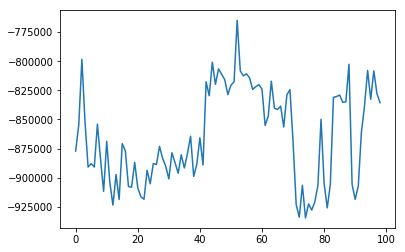

In [24]:
plt.plot(scores)

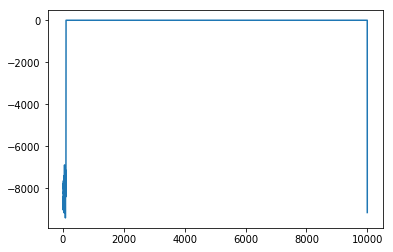

In [12]:
plt.plot(driver.reward_mem[:driver.mem_cntr])

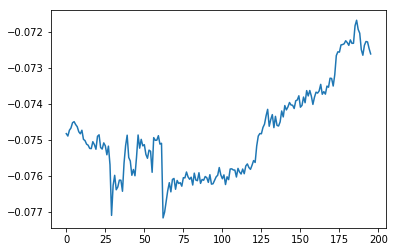

In [12]:
plt.plot(scores)

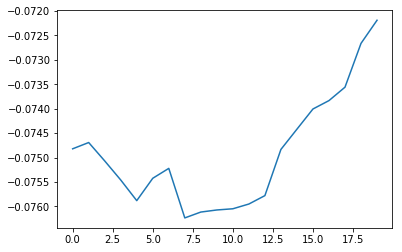

In [13]:
plt.plot(moving_avgs)

In [19]:
mx = driver.state_mem_stacked[driver.reward_mem.index(max(driver.reward_mem))][0]
mn = driver.state_mem_stacked[driver.reward_mem.index(min(driver.reward_mem))][0]

In [22]:
import cv2
cv2.imshow('image',mx)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [28]:
min(driver.reward_mem)

-9417.5

In [11]:
env.destroy()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!


In [15]:
# import time

# time.sleep(5)
# state = env.reset()
# done = False
# data = []
# i = 0
# while not done:
#     i += 1
#     print(i)
#     action = env.sample_action()
#     state_,reward,done = env.step(action)
#     data.append((state,action,state_,reward,done))
#     state = state_

In [ ]:
# import numpy as np
# import cv2
# import os 
# os.system('sudo modprobe bcm2835-v4l2') 
# cap = cv2.VideoCapture(0)
# import time
# t1 = time.time()
# # frames = np.zeros((500,480, 640))
# frames = []
# while True:
#     # Capture frame-by-frame
#     ret, frame = cap.read()
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     gray = gray[30:400,100:485]
#     gray = cv2.resize(gray,(100,100))
# #     frames.append(gray.copy())

#     # Display the resulting frame
#     cv2.imshow('frame',gray)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything done, release the capture
# # cap.release()
# # cv2.destroyAllWindows()
# t2 = time.time()
# print(t2-t1)

In [2]:
# env = Env()
# import time

# time.sleep(5)
# state = env.reset()
# done = False
# data = []
# i = 0
# while not done:
#     i += 1
#     print(i)
#     action = env.sample_action()
#     state_,reward,done = env.step(action)
#     data.append((state,action,state_,reward,done))
#     state = state_
    
# env.destroy()

# env.destroy()

# import cv2

# # dummy = data[20][0]
# dummy = data[17][0]
# dummy = dummy[:50]
# # upper = dummy[:50]
# # lower = dummy[50:]
# # np.sum(upper - lower)
# cv2.imshow('image',dummy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# np.sum(upper - lower)

# # dummy_base = dummy.copy()

# import numpy as np

# np.max(dummy_base)



# ds = []
# for i in range(50):
#     dummy = data[i][0]
# #     dummy = dummy[:10]
#     upper = dummy[:50]
#     lower = dummy[50:]
#     ds.append((np.sum(abs(upper - lower))/100000) - 3)
# #     ds.append((sum(sum(dummy_base - dummy)))/1000)

# import matplotlib.pyplot as plt

# plt.plot([l for i,j,k,l,m in data])



# plt.plot()



# # dummy = data[17][0]
# dummy = data[10][0]
# # dummy = dummy[60:70,30:50]
# cv2.imshow('image',dummy)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# dummy = data[23][0]
# dummy = dummy[:10]
# (sum(sum(dummy_base - dummy)))/1000

